In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyvisa
import pandas as pd
import nysg_tools as ny 
from scipy.signal import find_peaks

In [66]:
rm = pyvisa.ResourceManager()
rm.list_resources()

('USB0::0x0699::0x0353::1603569::INSTR',
 'USB0::0x0699::0x03C4::C010501::INSTR',
 'ASRL1::INSTR',
 'ASRL10::INSTR')

In [67]:
osci_name = "USB0::0x0699::0x03C4::C010501::INSTR"
fungen_name = "USB0::0x0699::0x0353::1603569::INSTR"

osci = rm.open_resource(osci_name)
fungen = rm.open_resource(fungen_name)

# CH1 -> INPUT
# CH2 -> OUTPUT

In [68]:
def get_osci(additional_info = False, plot=False):
    osci.write("DAT:SOU CH1")
    xze, xin = osci.query_ascii_values('WFMPRE:XZE?;XIN?', separator=';')
    yze1, ymu1, yoff1 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')
    osci.write("DAT:SOU CH2")

    yze2, ymu2, yoff2 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')

    osci.write('DAT:ENC RPB')
    osci.write('DAT:WID 1')

    osci.write("DAT:SOU CH1")
    data1 = osci.query_binary_values('CURV?', datatype='B', container=np.array)

    osci.write("DAT:SOU CH2")
    data2 = osci.query_binary_values('CURV?', datatype='B', container=np.array)

    tiempo = xze + np.arange(len(data1)) * xin

    data1v = (data1 - yoff1) * ymu1 + yze1
    data2v = (data2 - yoff2) * ymu2 + yze2
    
    if plot:
        plt.plot(tiempo,data1v)
        plt.plot(tiempo,data2v)

    if additional_info:
        extra = {"yze1":yze1,"ymu1":ymu1,"yoff1":yoff1,"yze2":yze2,"ymu2":ymu2,"yoff2":yoff2,"datach1raw":data1,"datach2raw":data2}
        return tiempo,data1v,data2v, extra

    return tiempo,data1v,data2v

def osci_autosave(filename,attrs,plot_saved=False):
    t,v1,v2 = get_osci()
    buffer =  pd.DataFrame({"time":t,"VCH1":v1,"VCH2":v2})

    buffer.attrs = attrs
    
    buffer.to_csv(f'{filename}{".csv"}')
    buffer.to_pickle(f'{filename}')

    if plot_saved:
        plt.plot(t,v1)
        plt.plot(t,v2)


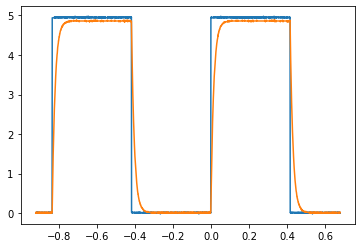

In [240]:
# # segunda data 

# attrs = {"Freq":2, "Res":46100,"cap":1*10**(-6),"amplt":5}

# osci_autosave("data/data2",attrs=attrs,plot_saved=True)

# tercera data 

# attrs = {"Freq":1.200, "Res":46100,"cap":1*10**(-6),"amplt":5}

# osci_autosave("data/data3",attrs=attrs,plot_saved=True)

# cuarta data 

# attrs = {"Freq":1.200, "Res":15000,"cap":1*10**(-6),"amplt":5}

#Esta es de 1.3 creo

# osci_autosave("data/data4",attrs=attrs,plot_saved=True)

#quinta data 

# attrs = {"Freq":1.200, "Res":30000,"cap":1*10**(-6),"amplt":5}

# osci_autosave("data/data5",attrs=attrs,plot_saved=True)

# sexta data 

# attrs = {"Freq":1.200, "Res":15000,"cap":1*10**(-6),"amplt":5}

# osci_autosave("data/data6",attrs=attrs,plot_saved=True)

#septima  data 

# attrs = {"Freq":1.200, "Res":60400,"cap":1*10**(-6),"amplt":5}
# osci_autosave("data/data7",attrs=attrs,plot_saved=True)

### Ajuste Primera data 
Ajuste con ~10K Ohm de resistencia y 1uF de capacitor

In [31]:
data = pd.read_pickle("data/data1")
t = data['time'].to_numpy()
vin = data['vin'].to_numpy()
vout = data['vout'].to_numpy()
print(data.attrs)

{'frecuencia': 8, 'tipo': 'cuadrada', 'volt': 5}


In [125]:
# peaks, _ = find_peaks(vout,height=-.3, distance=400)

# plt.scatter(t[wop],vout[wop],c='r')
# plt.plot(t,vout)

# vout[wop]
#Manual peaks: 1778 (2nd max) , 217 (first max), 998 #Min

In [59]:
x1 = t[217:998]
y1 = vout[217:998]
yerr1 = 0.04
xerr1 = np.full_like(x1,1/2500)
def discharge(par,x):
    return par[0] * np.exp(x/(par[1]))

def discharge_2(x,x0,a,b):
    return a * np.exp(-(x-x0)/b)

p1 = ny.fit_lsq(x1,y1,discharge_2,p0=[0.04,5,.01],yerr=np.full_like(y1,yerr1),maxfev=1000000000)

La función es:
None
Resultados del ajuste:
Parámetro x0: -0.07 ± 1659.538
Parámetro a: 10.585 ± 1775754.545
Parámetro b: 0.01 ± 0.0
Parametros de bondad:
ν: 777
χ²: 39.247
χ²/ν:0.051
Criterio 5%: (711.956, 842.044)


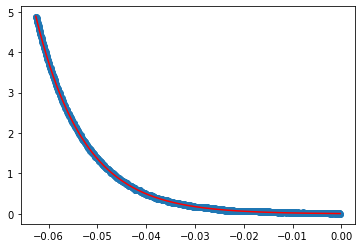

In [60]:
plt.scatter(x1,y1)
plt.plot(x1,discharge_2(x1,*p1['params']),c='r')

In [61]:
x2 = t[998:1778]
y2 = vout[998:1778]
yerr2 = 0.04
xerr2 = np.full_like(x2,1/2500)
def discharge(par,x):
    return par[0] * np.exp(x/(par[1]))

def discharge_21(x,x0,a,b):
    return a *(1- np.exp(-(x-x0)/b))

p2 = ny.fit_lsq(x2,y2,discharge_21,p0=[0,5,.01],yerr=np.full_like(y2,yerr2),maxfev=1000000000)

La función es:
None
Resultados del ajuste:
Parámetro x0: -0.0 ± 0.0
Parámetro a: 4.886 ± 0.001
Parámetro b: 0.01 ± 0.0
Parametros de bondad:
ν: 776
χ²: 41.937
χ²/ν:0.054
Criterio 5%: (710.998, 841.002)


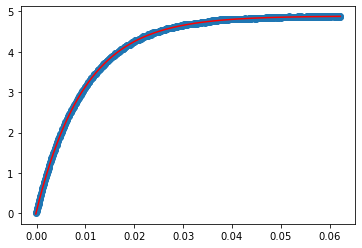

In [62]:
plt.scatter(x2,y2)
plt.plot(x2,discharge_21(x2,*p2['params']),c='r')

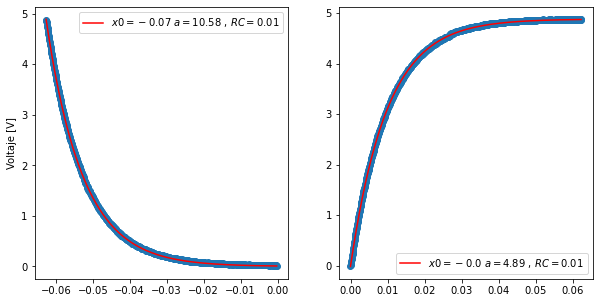

In [88]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,5))


ax0.scatter(x1,y1)
ax0.plot(x1,discharge_2(x1,*p1['params']),c='r',label=f"$x0 = {np.round(p1['params'][0],2)}$ $a= {np.round(p1['params'][1],2)}$ , $RC = {0.01}$")

ax1.scatter(x2,y2)

ax1.plot(x2,discharge_21(x2,*p2['params']),c='r',label=f"$x0 = {np.round(p2['params'][0],2)}$ $a= {np.round(p2['params'][1],2)}$ , $RC = {0.01}$")

ax0.set_ylabel("Voltaje [V]")

# ax1.plot(x2,discharge_2(x2,*p2['params']),c='r',label=f"$a = {np.round(p2['params'][0],2)}$ $x0= {np.round(p2['params'][1],2)}$ , $RC = {0.01}$")

ax1.legend()

ax0.legend()

plt.savefig("figuras/ajuste.pdf")

# Inductancia

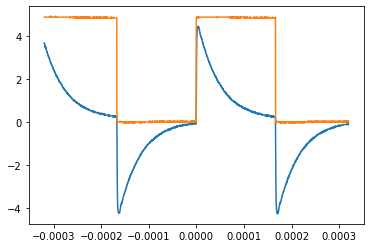

In [6]:
#data 1 

# attrs = {"Freq":3000, "Res":2200,"ind":1*10**(-3),"amplt":5}#
# y aca creo que es 100 xd 

# osci_autosave("data_inductancia/idata1",attrs=attrs,plot_saved=True)

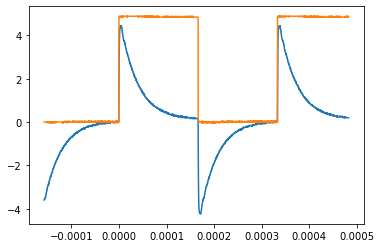

In [8]:
#data 2 

# attrs = {"Freq":100000, "Res":2200,"ind":8*10**(-3),"amplt":5}#

#aca creo que es 80 xd 

# osci_autosave("data_inductancia/idata2",attrs=attrs,plot_saved=True)

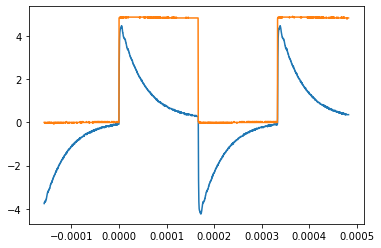

In [29]:
#data 3

# attrs = {"Freq":3000, "Res":2200,"ind":170*10**(-3),"amplt":5}#


# osci_autosave("data_inductancia/idata3",attrs=attrs,plot_saved=True)

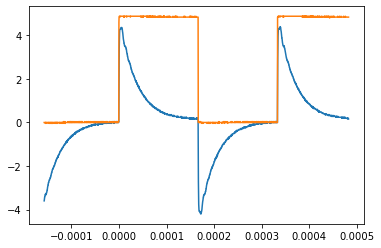

In [30]:
#data 4

# attrs = {"Freq":3000, "Res":2200,"ind":77*10**(-3),"amplt":5}#


# osci_autosave("data_inductancia/idata4",attrs=attrs,plot_saved=True)

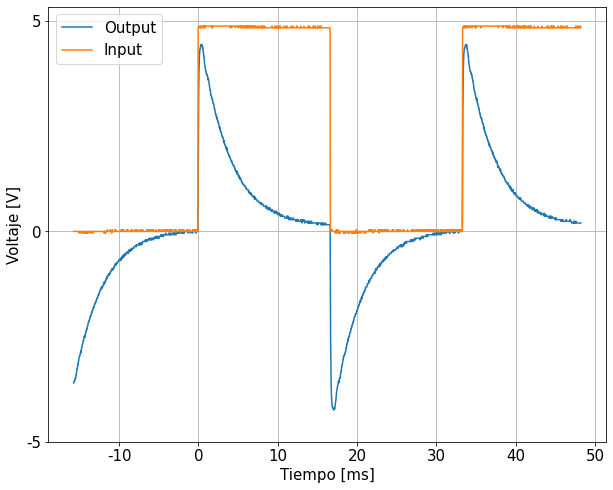

In [26]:
a = pd.read_pickle('data_inductancia/idata2')
plt.figure(figsize=(10,8))
plt.plot(a['time'],a['VCH1'],label="Output")
plt.plot(a['time'],a['VCH2'],label='Input')
plt.xlabel("Tiempo [ms]",fontsize=15)
plt.ylabel("Voltaje [V]",fontsize=15)
plt.legend(fontsize=15)
plt.xticks([-0.0001,0,0.0001,0.0002,0.0003,0.0004,0.0005],["-10","0","10","20","30","40","50"],fontsize=15)
plt.yticks([-5,0,5],["-5","0","5"],fontsize=15)
plt.grid()
plt.savefig('figuras/inductancia.pdf',dpi=300)

In [89]:
import time

#freq = [200,500,800,900,1000,1300,1400,1500,1700,1800,1900,2000,2100,2500,2300,2400,2800,3000,3200,3400,3600,3800,4000] #Nuevos datos
freq = np.logspace(4,7,23,dtype=int)

overf = 1/np.array(freq)


#1000, 5000, 10000, 15000, 30000,45000, 60000, 100000, 150000,200000, 500000

for (i,freq) in enumerate(freq):

    #seteo la frecuencia en el generador de funciones.
    fungen.write(f'SOURCE1:FREQ {freq}')

    t, v1, v2 = get_osci()

    vals = pd.DataFrame({"time":t,"v1":v1,"v2":v2})


    # setea la escala en el osciloscopio---- tiene que estar antes por eso no se ve bien el primer archivo.
    osci.write(f"HOR:MAI:SCALE {3/10 * 0.8 *overf[i]}")

    time.sleep(0.5)
    
    # guardamos datos en el dataframe y luego en el archvivo.
    data = pd.DataFrame({"time":t,"v1":v1,"v2":v2})
    data.to_csv(f'data_resistencia/data_resistencia(4,7,23)/rdata{i}')

#los otros eran 4 a 5 y el otro 4 a 6 